## Deeper into DeepTrain
This example assumes you've read `basic.ipynb`, and covers:

  - Multi-phase training
      - Changing loss & hyperparameters between phases
  - Callback streaming images to directory
  - Saving & loading
  - Variable-layer model building

In [1]:
import os
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model

from deeptrain import TrainGenerator, DataGenerator
from deeptrain.callbacks import VizAE2D

In [2]:
%config InlineBackend.figure_format = 'retina'  # greatly improve display quality

### Configuration

In [3]:
# This scheme enables variable number of layers
def make_model(batch_shape, optimizer, loss, metrics,
               filters, kernel_size, strides, activation, up_sampling_2d,
               input_dropout, preout_dropout):
    """Compressing, denoising AutoEncoder."""
    ipt = Input(batch_shape=batch_shape)
    x   = Dropout(input_dropout)(ipt)

    configs = (activation, filters, kernel_size, strides, up_sampling_2d)
    for a, f, ks, s, ups in zip(*configs):
        x = UpSampling2D(ups)(x) if ups else x
        x = Conv2D(f, ks, strides=s, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation(a)(x)

    x   = Dropout(preout_dropout)(x)
    x   = Conv2D(1, (3, 3), strides=1, padding='same', activation='sigmoid')(x)
    out = x

    model = Model(ipt, out)
    model.compile(optimizer, loss, metrics=metrics)
    return model

In [4]:
batch_size = 128
width, height, channels = 28, 28, 1
# 28x compression
MODEL_CFG = dict(
    batch_shape=(batch_size, width, height, channels),
    loss='mse',
    metrics=None,
    optimizer='nadam',
    activation=['relu'] * 5,
    filters=[6, 12, 2, 6, 12],
    kernel_size=[(3, 3)] * 5,
    strides=[(2, 2), (2, 2), 1, 1, 1],
    up_sampling_2d=[None, None, None, (2, 2), (2, 2)],
    input_dropout=.5,
    preout_dropout=.4,
)
datadir = os.path.join("dir", "data", "image")
DATAGEN_CFG = dict(
    data_path=os.path.join(datadir, 'train'),
    batch_size=batch_size,
    shuffle=True,
    superbatch_set_nums='all',
)
VAL_DATAGEN_CFG = dict(
    data_path=os.path.join(datadir, 'val'),
    batch_size=batch_size,
    shuffle=False,
    superbatch_set_nums='all',
)

- `key_metric`: the metric that decides the "best" model
- `max_is_best`: whether greater `key_metric` is better (we seek to minimize loss)
- `input_as_labels`: y = x, or model.fit(x, x)
- `eval_fn`: function to use in validation
- `val_freq`:               how often to validate     (default: every epoch)
- `plot_history_freq`:      how often to plot history (default: every epoch)
- `unique_checkpoint_freq`: how often to checkpoint   (default: every epoch)
- `model_save_kw`: kwargs passed to `model.save()`. Exclude optimizer since we'll save its (and model's)<br> weights separately to load later
- `model_name_configs`: set which model attributes to include in automatic name generation, and their (shortened) aliases

In [5]:
TRAINGEN_CFG = dict(
    epochs=6,
    logs_dir=os.path.join('dir', 'outputs', 'logs'),
    best_models_dir=os.path.join('dir', 'outputs', 'models'),
    model_configs=MODEL_CFG,
    key_metric='mae',
    max_is_best=False,
    input_as_labels=True,
    eval_fn='predict',
    val_freq={'epoch': 2},
    plot_history_freq={'epoch': 2},
    unique_checkpoint_freq={'epoch': 2},
    iter_verbosity=0,  # silence per-iteration progress printing (to spare notebook length)
    model_save_kw=dict(include_optimizer=False, save_format='h5'),
    model_name_configs=dict(input_dropout='idp', preout_dropout='pdp',
                            optimizer='', lr='', best_key_metric=None)
)

### Create visualization callback

In [6]:
TRAINGEN_CFG['callbacks'] = [VizAE2D(n_images=8, save_images=True)]

### Create training objects

In [7]:
model = make_model(**MODEL_CFG)
dg    = DataGenerator(**DATAGEN_CFG)
vdg   = DataGenerator(**VAL_DATAGEN_CFG)
tg    = TrainGenerator(model, dg, vdg, **TRAINGEN_CFG)

# save optimizer weights & attrs to load later
_ = tg.saveskip_list.pop(tg.saveskip_list.index('optimizer_state'))

Discovered 48 files with matching format
48 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
Discovered 36 files with matching format
36 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
NOTE: will exclude `labels` from saving when `input_as_labels=True`; to keep 'labels', add '{labels}'to `saveskip_list` instead
Preloading superbatch ... WARNING: multiple file extensions found in `path`; only .npy will be used 
Discovered 48 files with matching format
................................................ finished, w/ 6144 total samples
Train initial data prepared
Preloading superbatch ... WARNING: multiple file extensions found in `path`; only .npy will be used 
Discovered 36 files with matching format
.................................... finished, w/ 4608 total samples


### Train


Data set_nums shuffled


_____________________
 EPOCH 1 -- COMPLETE 


Data set_nums shuffled


_____________________
 EPOCH 2 -- COMPLETE 



Validating...
TrainGenerator state saved
Model report generated and saved
Best model saved to dir\outputs\models\M21__model-idp.5-pdp.4-nadam__min.200
TrainGenerator state saved
Model report generated and saved


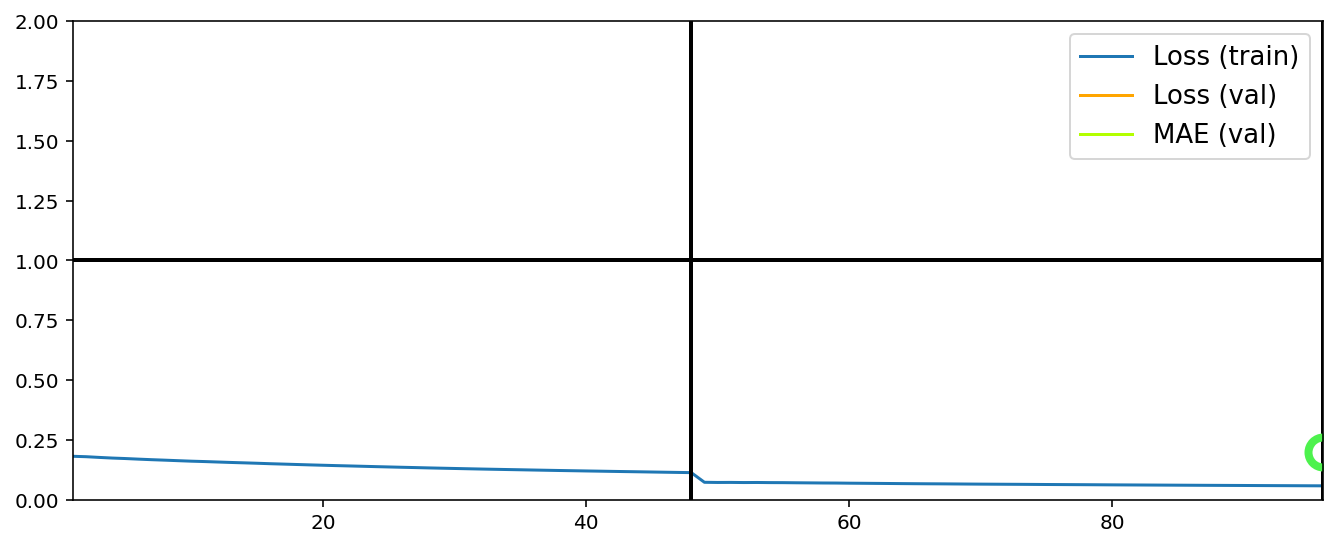

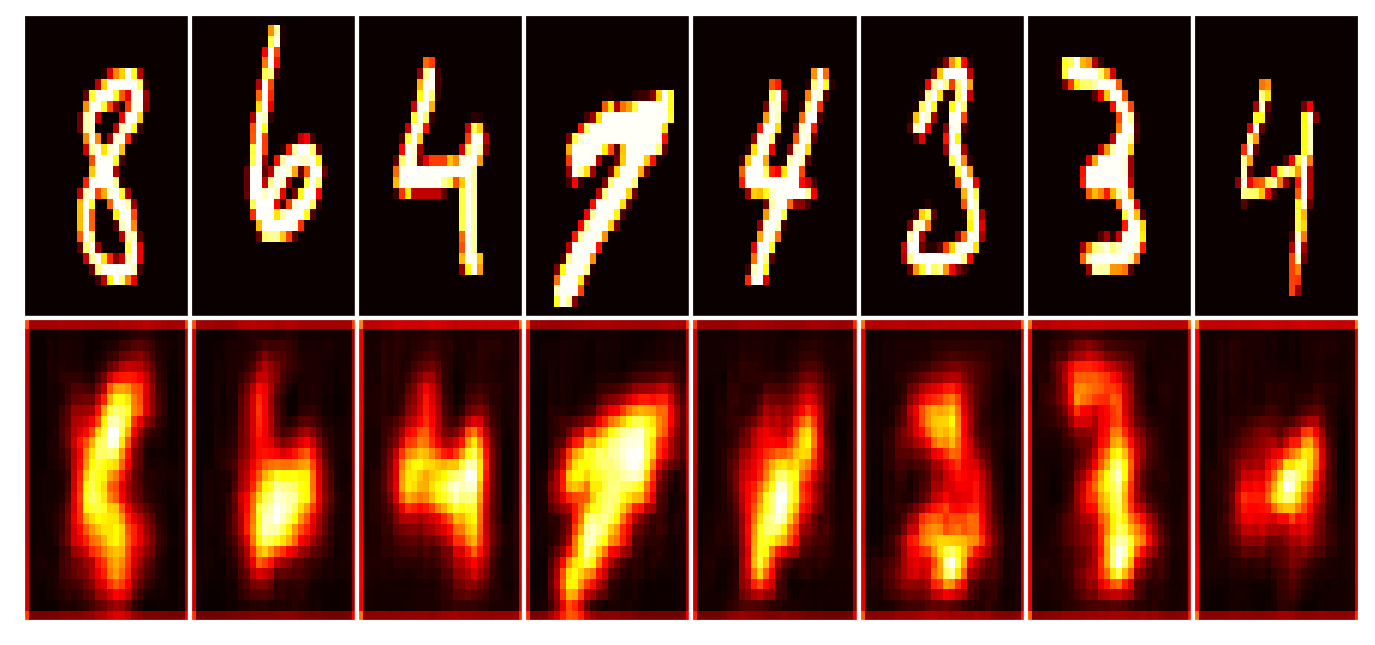


Data set_nums shuffled


_____________________
 EPOCH 3 -- COMPLETE 


Data set_nums shuffled


_____________________
 EPOCH 4 -- COMPLETE 



Validating...
TrainGenerator state saved
Model report generated and saved
Best model saved to dir\outputs\models\M21__model-idp.5-pdp.4-nadam__min.114
TrainGenerator state saved
Model report generated and saved


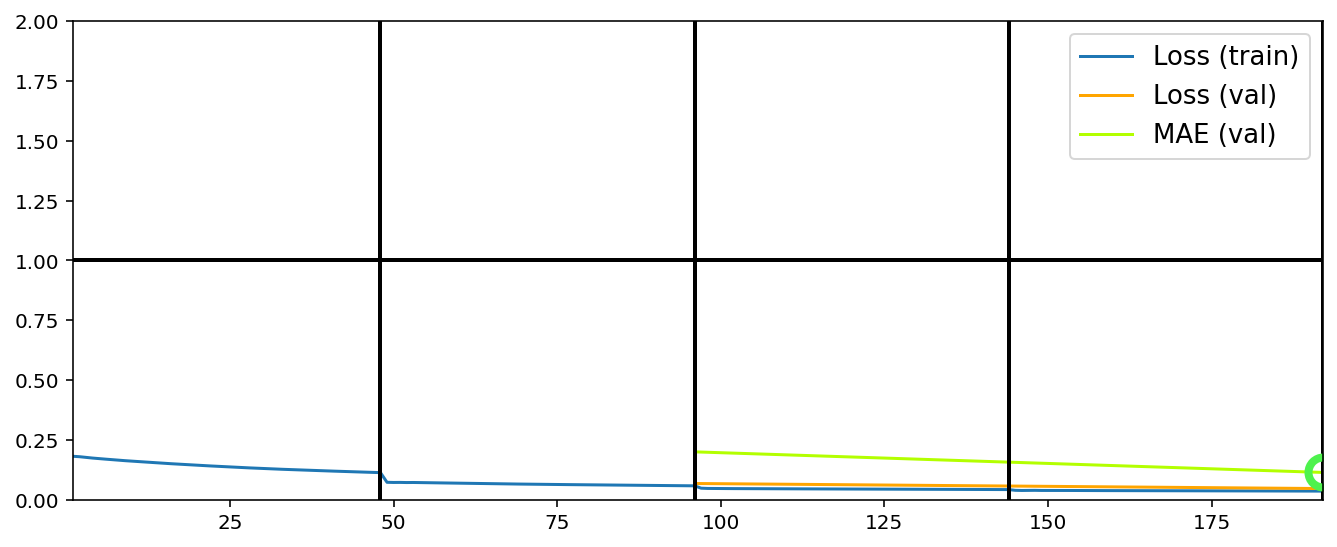

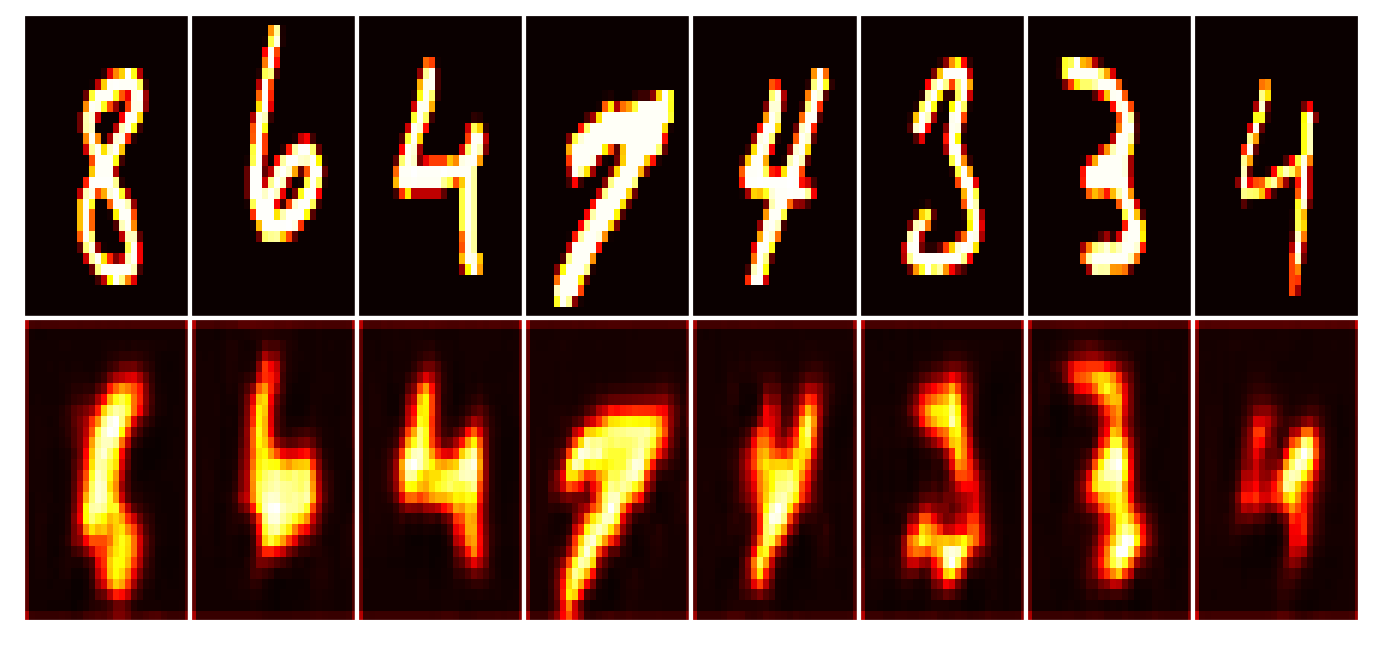


Data set_nums shuffled


_____________________
 EPOCH 5 -- COMPLETE 


Data set_nums shuffled


_____________________
 EPOCH 6 -- COMPLETE 



Validating...
TrainGenerator state saved
Model report generated and saved
Best model saved to dir\outputs\models\M21__model-idp.5-pdp.4-nadam__min.084
TrainGenerator state saved
Model report generated and saved


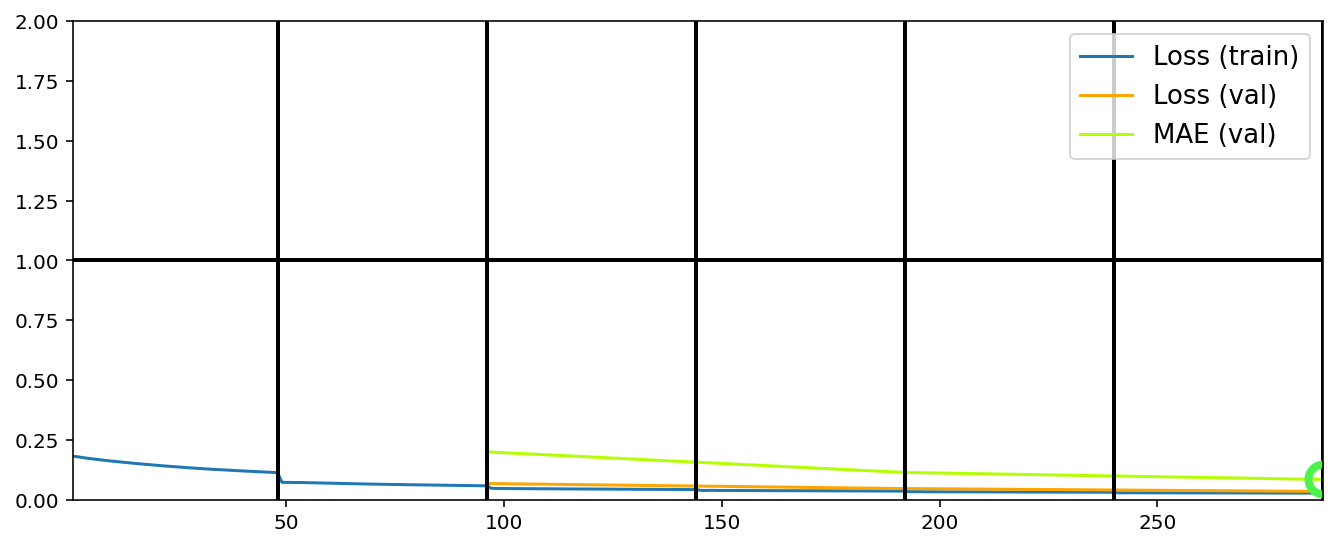

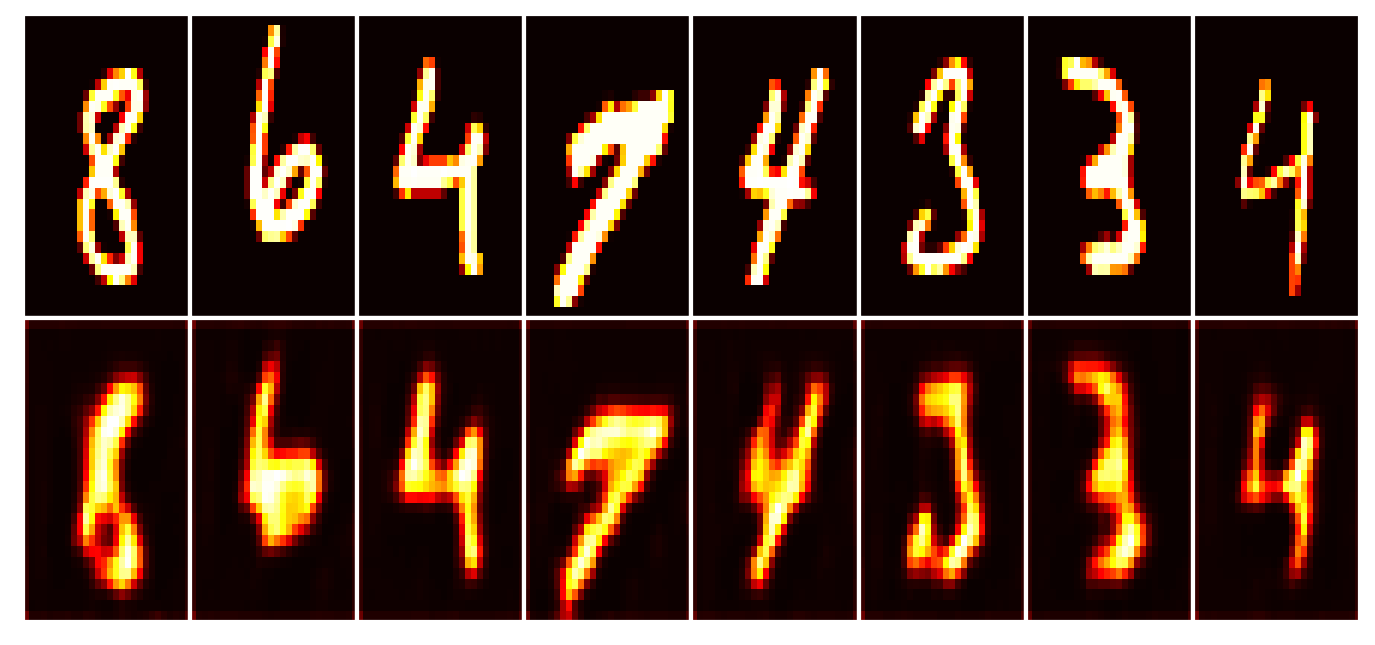

Training has concluded.


In [8]:
tg.train()

### Phase 2
Switch to *mean absolute error* loss; greater penalty to smaller errors forces better image resolution. <br>
Internally, TrainGenerator will append `'mae'` loss to same list as was `'mse'`.


Data set_nums shuffled


_____________________
 EPOCH 7 -- COMPLETE 


Data set_nums shuffled


_____________________
 EPOCH 8 -- COMPLETE 



Validating...
TrainGenerator state saved
Model report generated and saved
Best model saved to dir\outputs\models\M21__model-idp.5-pdp.4-nadam__min.063
TrainGenerator state saved
Model report generated and saved


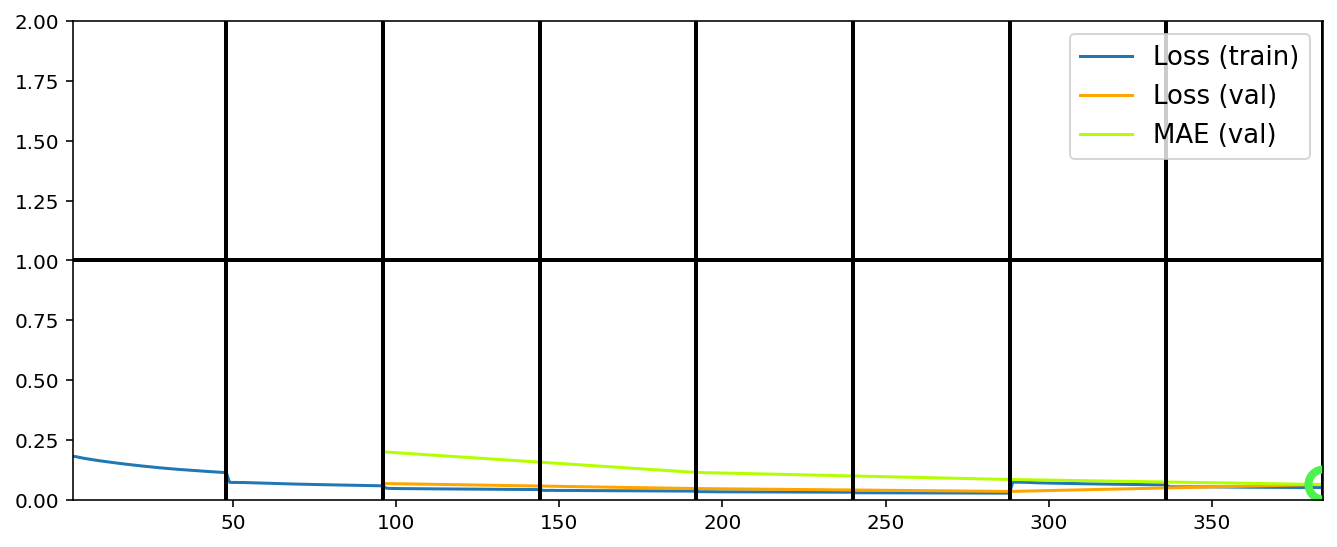

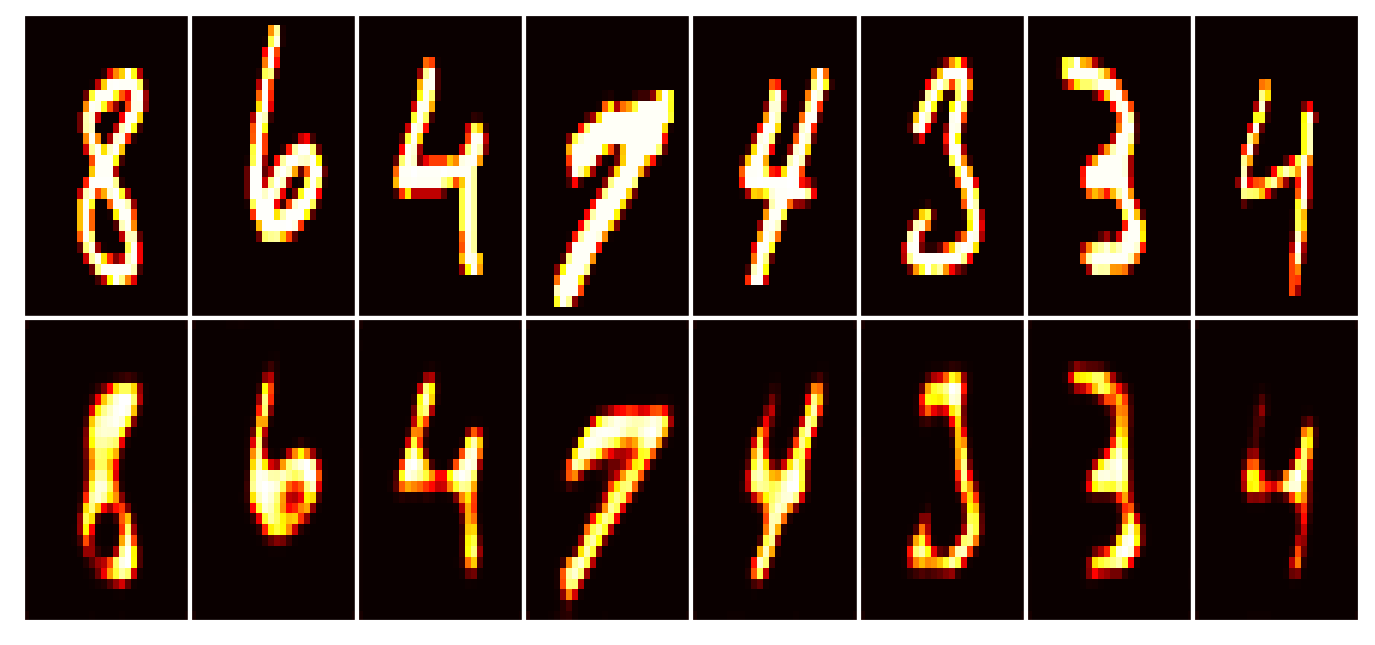


Data set_nums shuffled


_____________________
 EPOCH 9 -- COMPLETE 


Data set_nums shuffled


______________________
 EPOCH 10 -- COMPLETE 



Validating...
TrainGenerator state saved
Model report generated and saved
Best model saved to dir\outputs\models\M21__model-idp.5-pdp.4-nadam__min.058
TrainGenerator state saved
Model report generated and saved


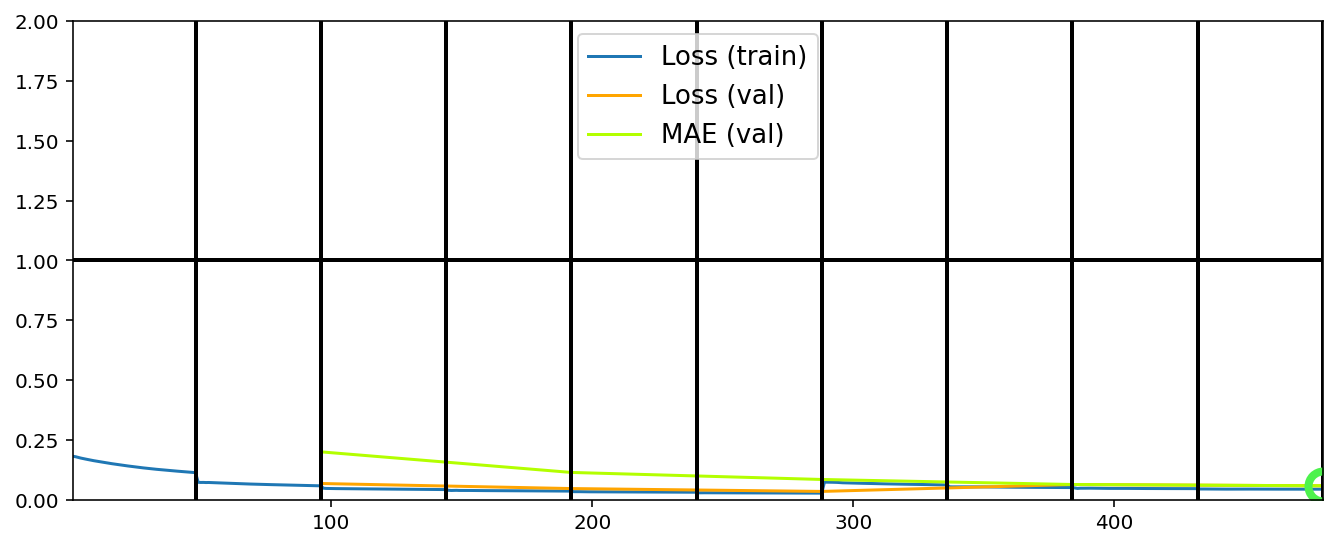

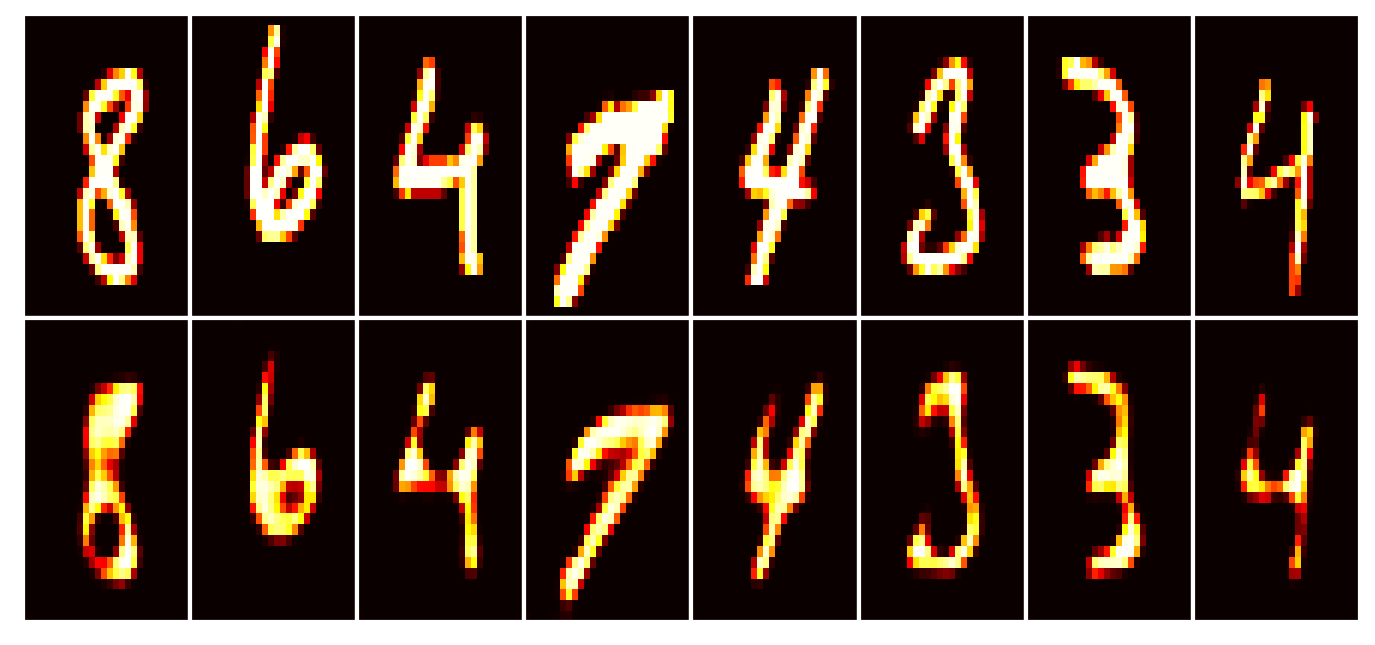


Data set_nums shuffled


______________________
 EPOCH 11 -- COMPLETE 


Data set_nums shuffled


______________________
 EPOCH 12 -- COMPLETE 



Validating...
TrainGenerator state saved
Model report generated and saved
Best model saved to dir\outputs\models\M21__model-idp.5-pdp.4-nadam__min.046
TrainGenerator state saved
Model report generated and saved


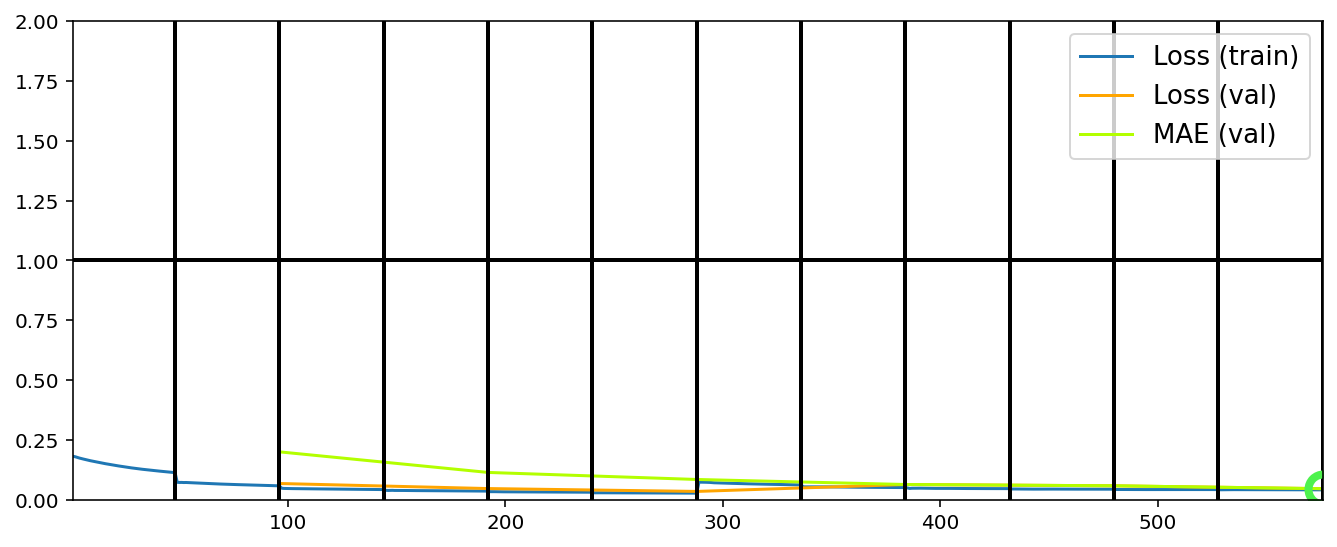

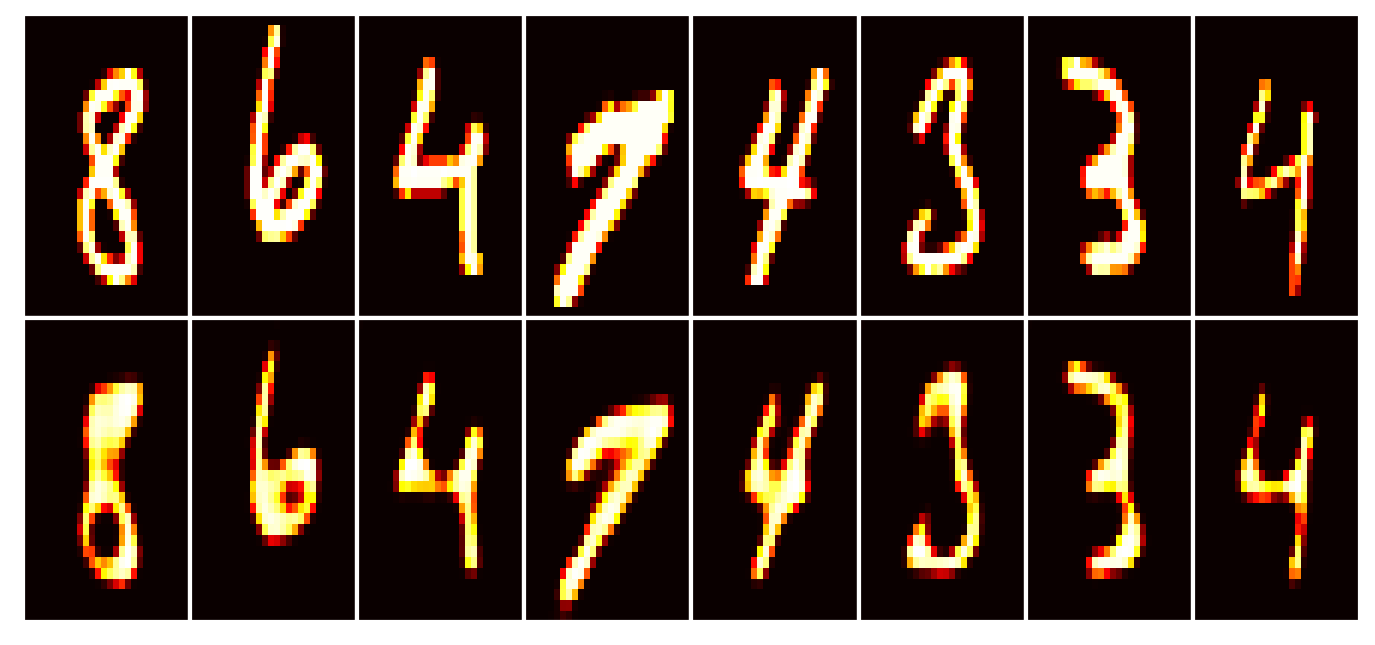

Training has concluded.


In [9]:
tg.model.compile(MODEL_CFG['optimizer'], 'mae')
tg.epochs = 12
tg.train()

### New session w/ changed hyperparams

In [10]:
# get best save's model weights & TrainGenerator state
latest_best_weights = tg.get_last_log('weights', best=True)
latest_best_state   = tg.get_last_log('state',   best=True)

# destroy existing train objects
tg.destroy(confirm=True)
del model, dg, vdg, tg

# increase preout_dropout to strengthen regularization
MODEL_CFG['preout_dropout'] = .7
MODEL_CFG['loss'] = 'mae'
# `epochs` will load at 12, so need to increase
TRAINGEN_CFG['epochs'] = 20
TRAINGEN_CFG['loadpath'] = latest_best_state
# ensure model_name uses prev model_num + 1, since using new hyperparams
TRAINGEN_CFG['new_model_num'] = False
# must re-instantiate callbacks object to hold new TrainGenerator
TRAINGEN_CFG['callbacks'] = [VizAE2D(n_images=8, save_images=True)]

>>>TrainGenerator DESTROYED


### Create new train objects

In [11]:
model = make_model(**MODEL_CFG)
model.load_weights(latest_best_weights)

dg    = DataGenerator(**DATAGEN_CFG)
vdg   = DataGenerator(**VAL_DATAGEN_CFG)
tg    = TrainGenerator(model, dg, vdg, **TRAINGEN_CFG)
# can also load via `tg.load`, but passing in `loadpath` and starting a
# new session should work better

Discovered 48 files with matching format
48 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
Discovered 36 files with matching format
36 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
NOTE: will exclude `labels` from saving when `input_as_labels=True`; to keep 'labels', add '{labels}'to `saveskip_list` instead
Optimizer state loaded (& cleared from TrainGenerator)
TrainGenerator state loaded from dir\outputs\models\M21__model-idp.5-pdp.4-nadam__min.046__state.h5
--Preloading excluded data based on datagen states ...
Preloading superbatch ... WARNING: multiple file extensions found in `path`; only .npy will be used 
Discovered 48 files with matching format
................................................ finished, w/ 6144 total samples
Train initial data prepared
P

### Train


Data set_nums shuffled


______________________
 EPOCH 13 -- COMPLETE 


Data set_nums shuffled


______________________
 EPOCH 14 -- COMPLETE 



Validating...
TrainGenerator state saved
Model report generated and saved
Best model saved to dir\outputs\models\M22__model-idp.5-pdp.7-nadam__min.039
TrainGenerator state saved
Model report generated and saved


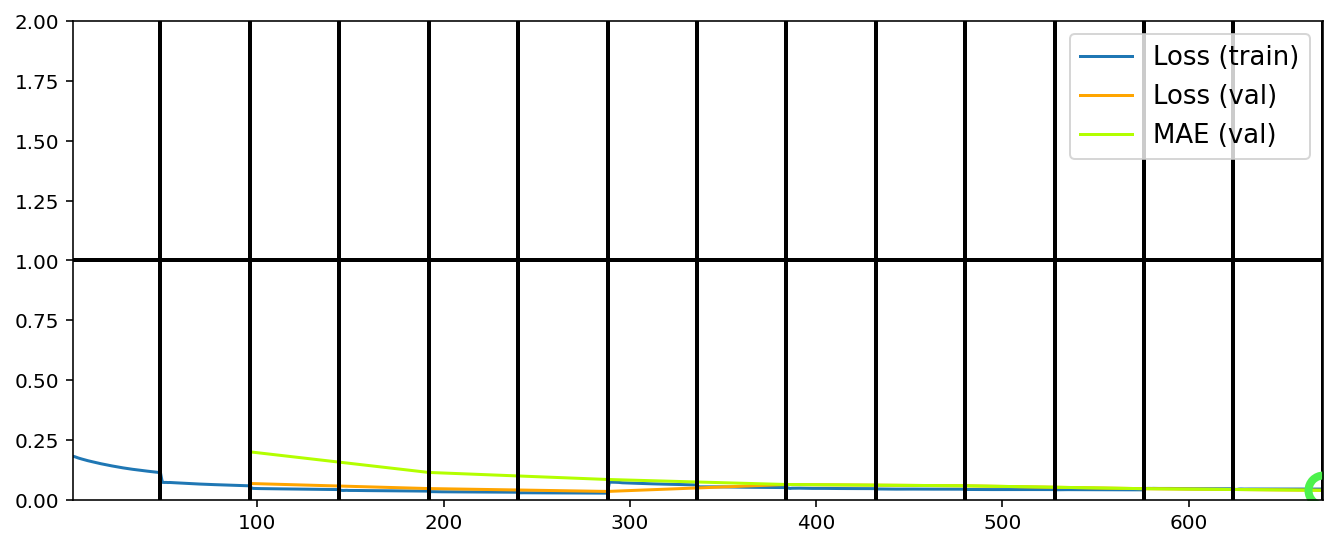

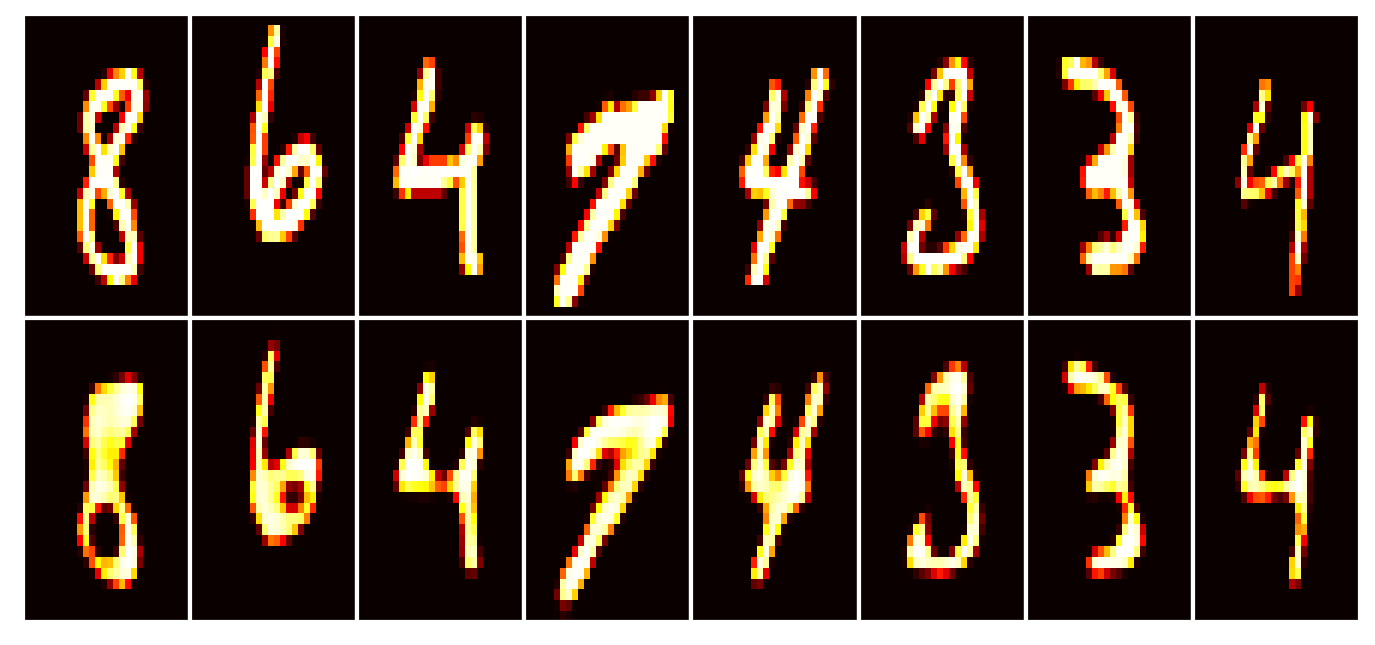


Data set_nums shuffled


______________________
 EPOCH 15 -- COMPLETE 


Data set_nums shuffled


______________________
 EPOCH 16 -- COMPLETE 



Validating...
TrainGenerator state saved
Model report generated and saved
Best model saved to dir\outputs\models\M22__model-idp.5-pdp.7-nadam__min.038
TrainGenerator state saved
Model report generated and saved


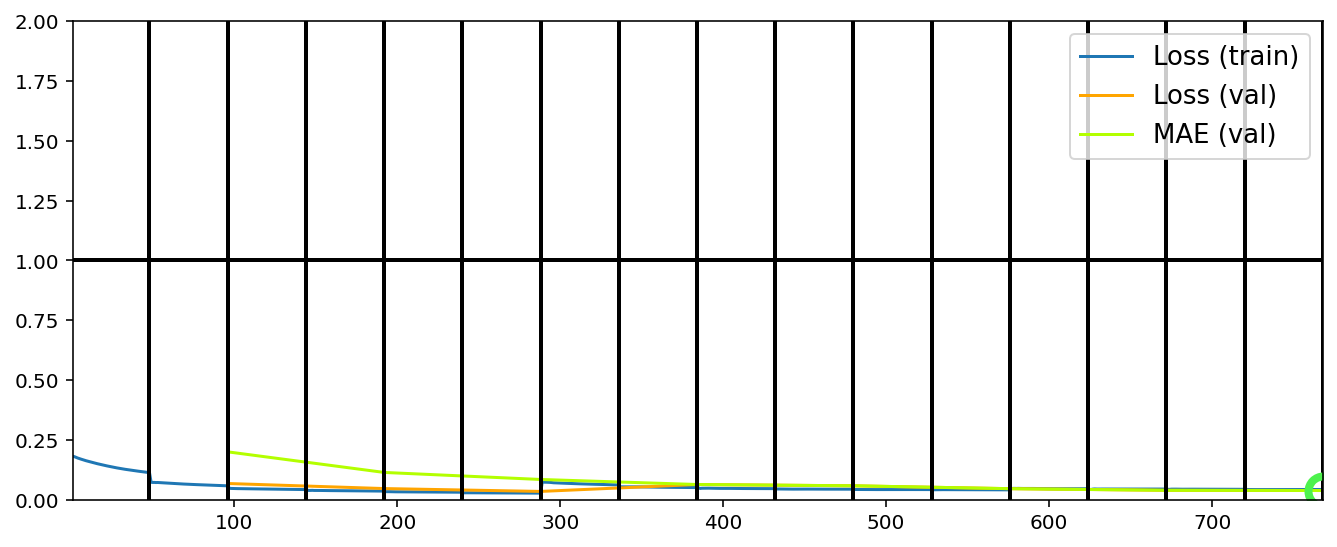

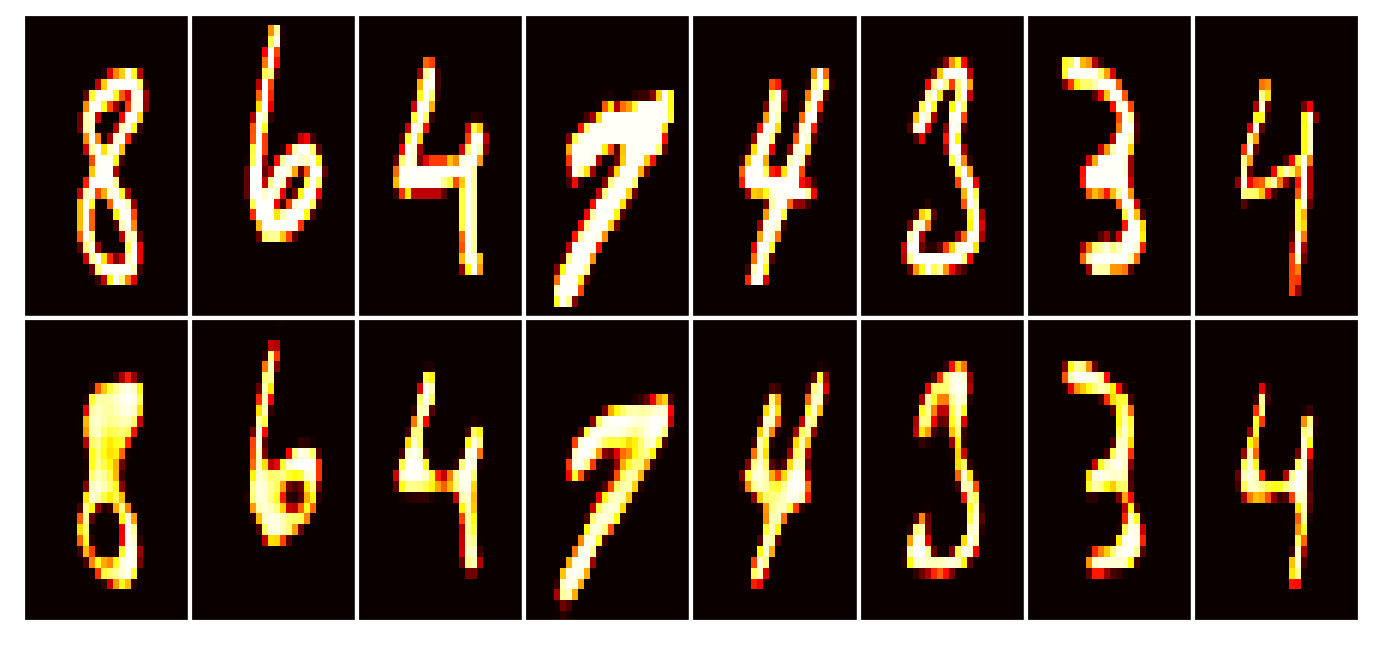


Data set_nums shuffled


______________________
 EPOCH 17 -- COMPLETE 


Data set_nums shuffled


______________________
 EPOCH 18 -- COMPLETE 



Validating...
TrainGenerator state saved
Model report generated and saved


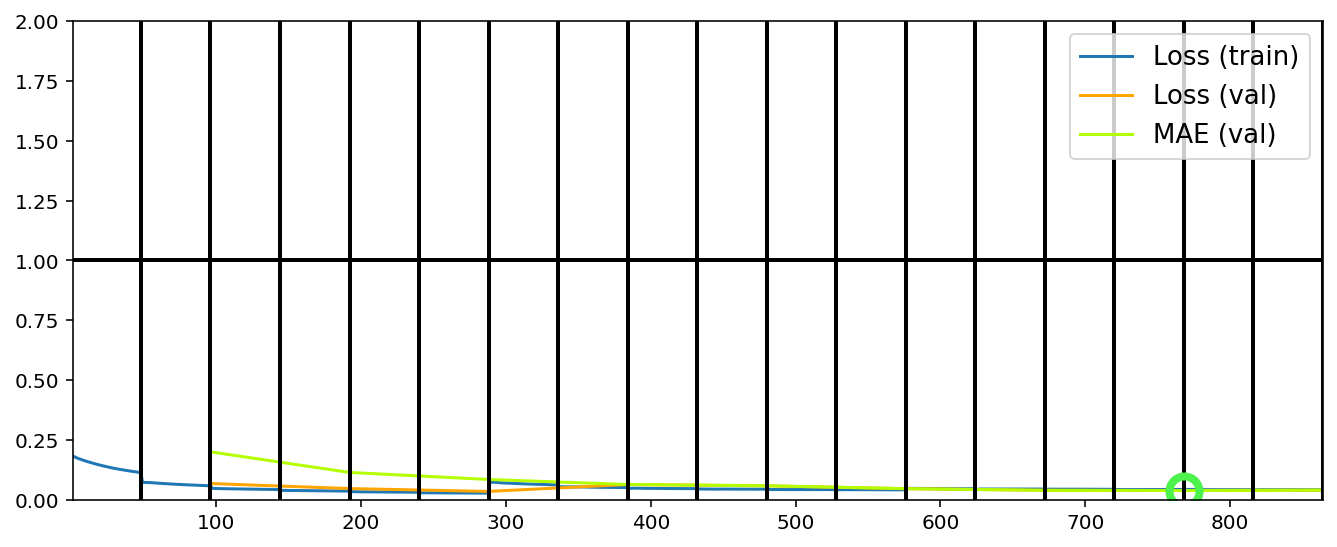

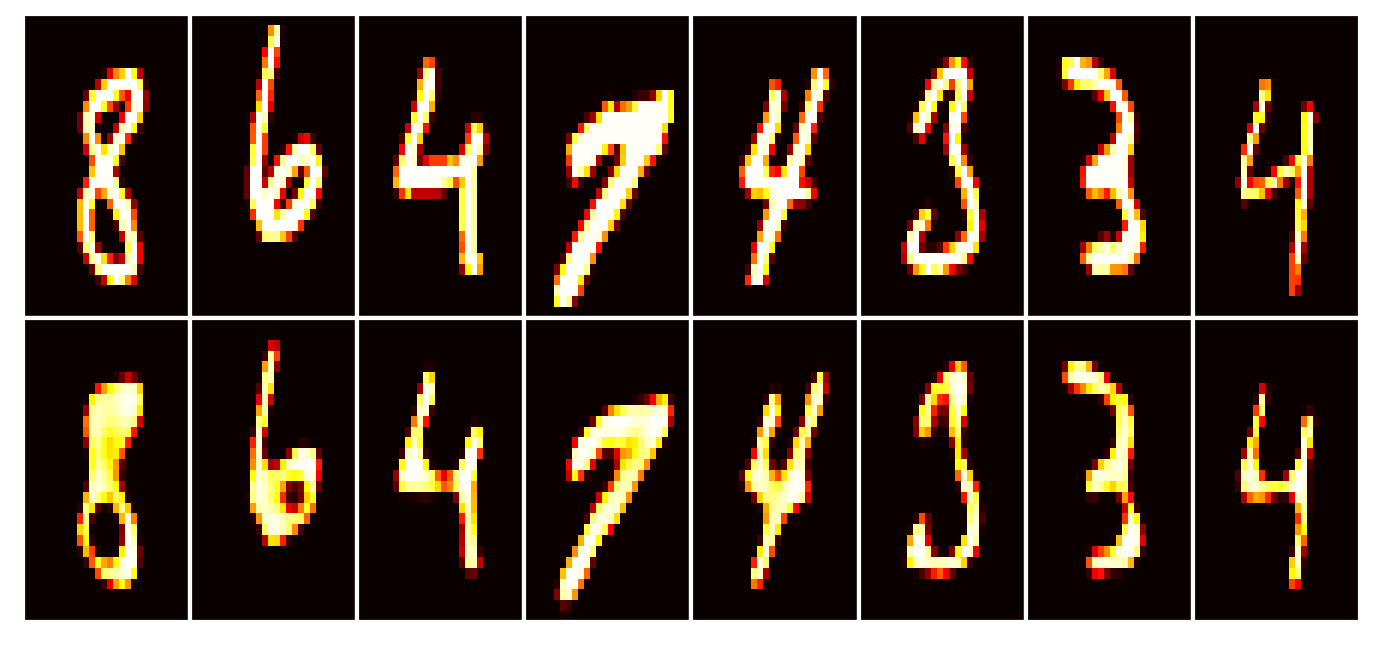


Data set_nums shuffled


______________________
 EPOCH 19 -- COMPLETE 


Data set_nums shuffled


______________________
 EPOCH 20 -- COMPLETE 



Validating...
TrainGenerator state saved
Model report generated and saved


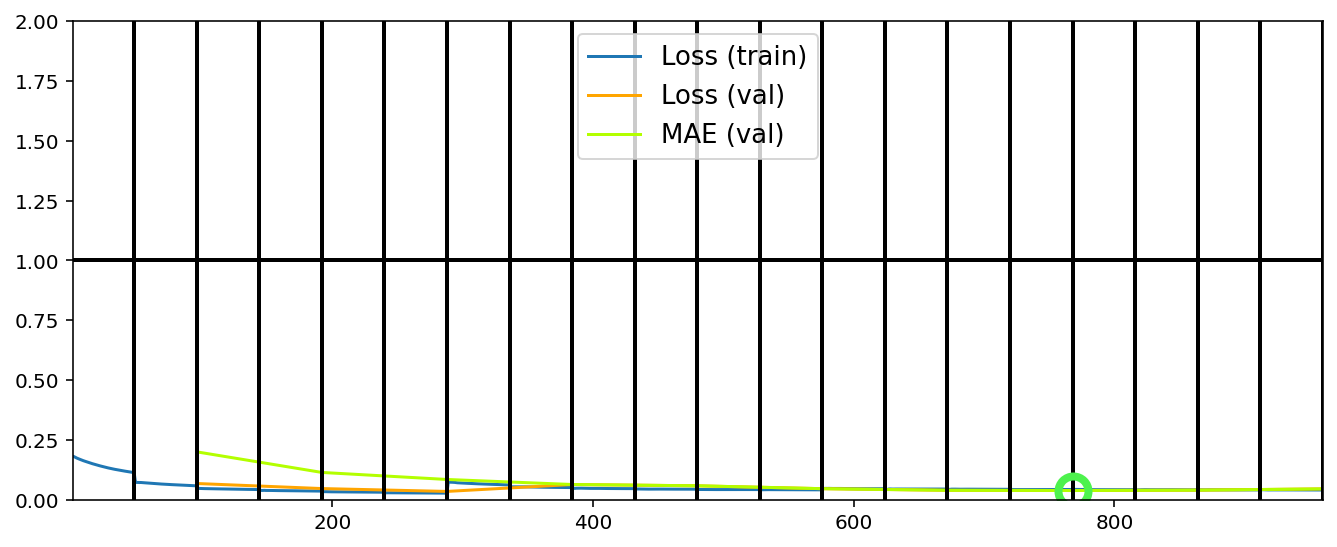

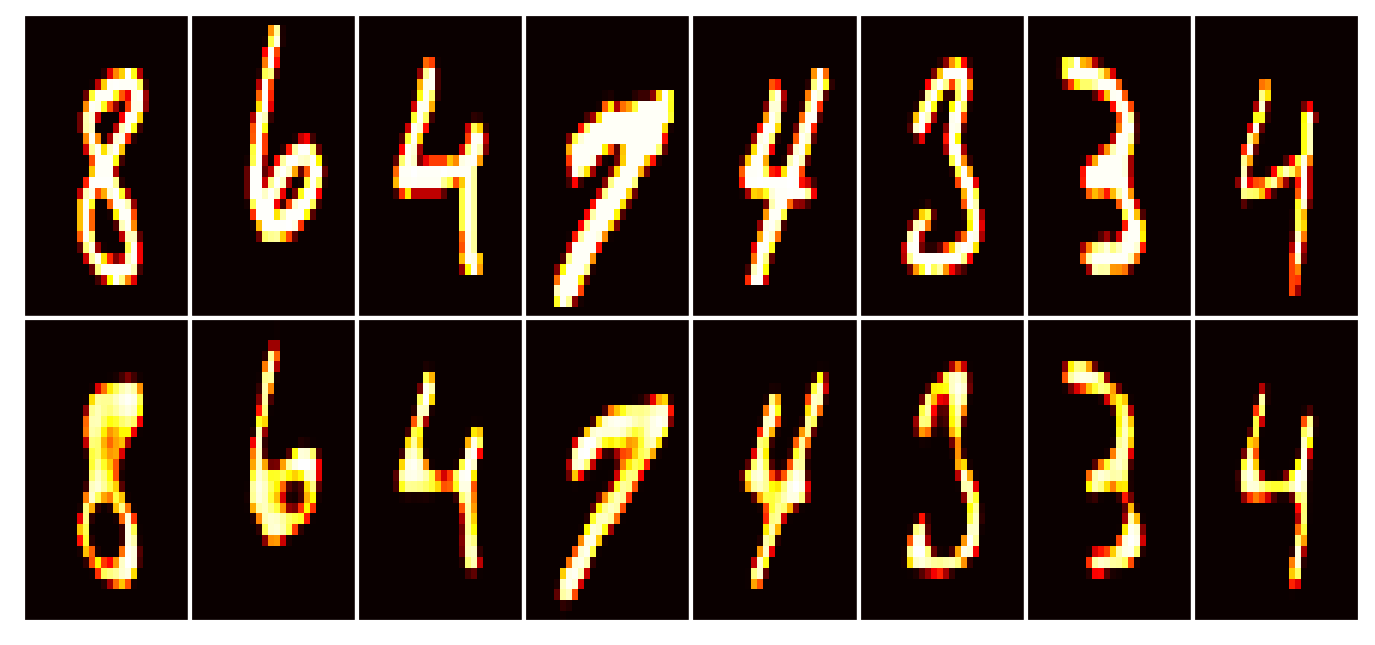

Training has concluded.


In [12]:
tg.train()

In [13]:
cwd = os.getcwd()
print("Checkpoints can be found in", os.path.join(cwd, tg.logdir))
print("Best model can be found in",  os.path.join(cwd, tg.best_models_dir))
print("AE progress can be found in", os.path.join(cwd, tg.logdir, 'misc'))

Checkpoints can be found in C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logs\M22__model-idp.5-pdp.7-nadam__min.046
Best model can be found in C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\models
AE progress can be found in C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logs\M22__model-idp.5-pdp.7-nadam__min.046\misc


### Inspect generated logs
Our callback is configured to write images to `tg.logdir + '/misc'`, and there's further the "report" of the train state.<br>
Open the last directory named above, also one of the *previous* model number (since we reinstantiated in Phase 2), to see the callbacks' outputs.<br>
Below we'll look at the last generated report (viewed better by opening the image file):

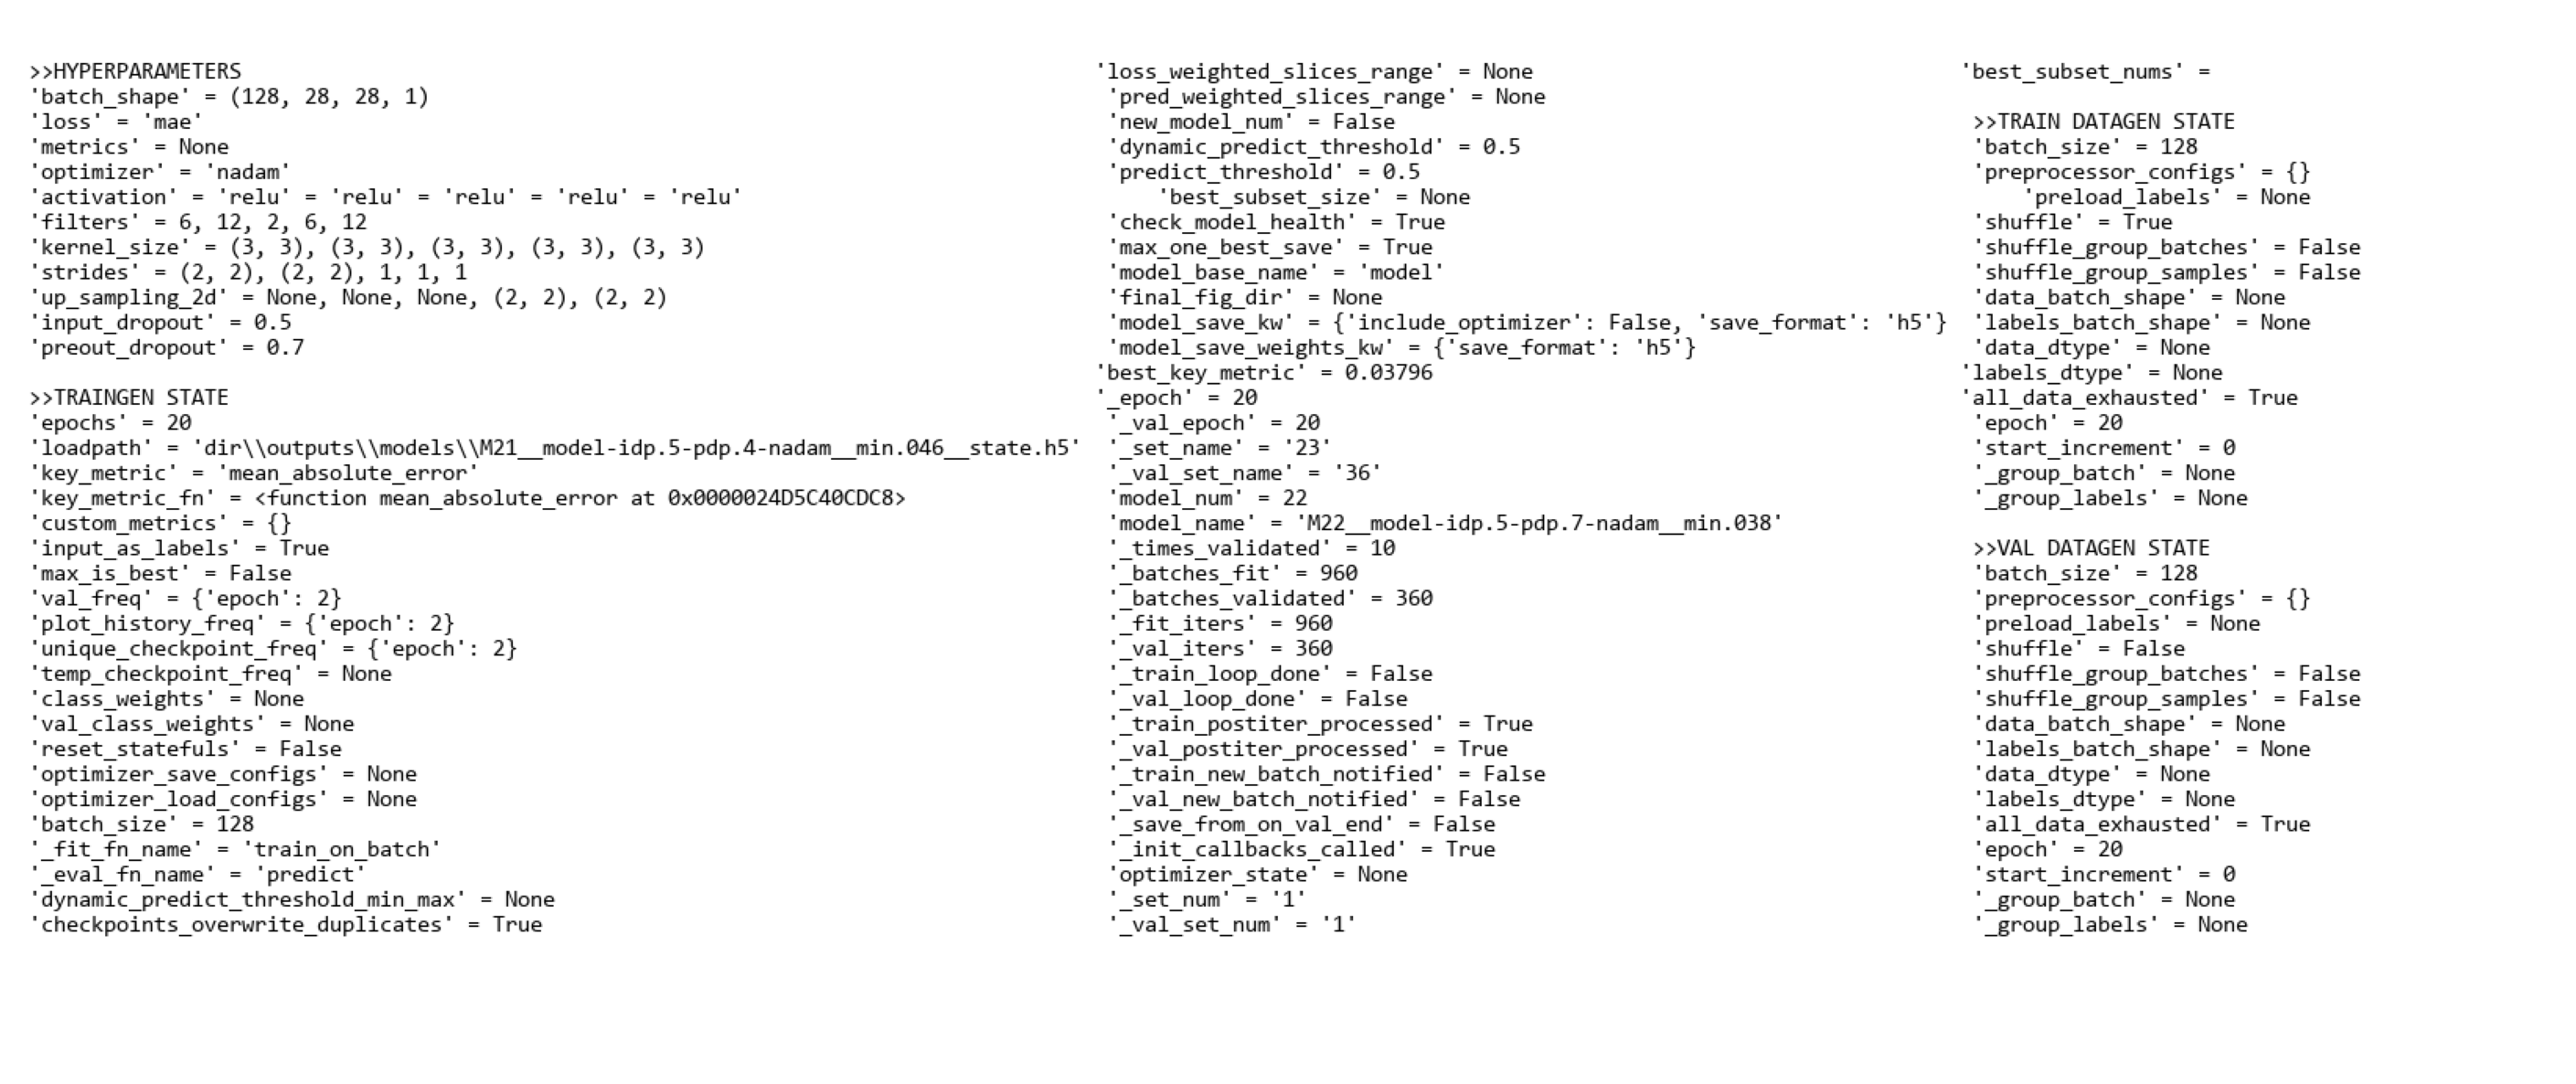

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(tg.get_last_log('report'))
_, ax = plt.subplots(figsize=(25, 25))
ax.imshow(img)
ax.set_axis_off()
plt.show()

Report generation, including which attributes to include or exclude, is configured in `util/configs.py`, or overridden by the `report_configs` kwarg to `TrainGenerator`. We can configure it to display the most relevant info, and discard the rest. The train state should more completely be saved in the `__state.h5` file, loaded via `tg.load()`.